In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import HelperFunctions as hf


## Load data

In [4]:
calendar, sell_price, sales_evaluation, sales_validation = load_data()


Loading data Done.


In [5]:
sampled_item_ids = stratified_sample(sales_validation)


In [21]:
len(sampled_item_ids)

1000

## Clean/Transform data


In [26]:
df = generate_data(sales_validation, sampled_item_ids, dataSource='train', day_cut=1300)


Combining data Done.
Cleaning data Done.
Reduce memory Done.


In [27]:
df['d'].min(), df['d'].max()

(56, 1300)

## Split-Train

In [28]:
d_start = int(max(df['d'])) - 100

train_set = df[df['d'] <= d_start]
test_set = df[(df['d'] > d_start)]

X_train = train_set[train_set.columns[train_set.columns != 'sold']]
y_train = train_set['sold']

X_test = test_set[test_set.columns[test_set.columns != 'sold']]
y_test = test_set['sold']

X_train = X_train.loc[:, ~X_train.columns.isin(['id', 'd'])] # 'id', 'd', 'item_id'
X_test = X_test.loc[:, ~X_test.columns.isin(['id', 'd'])]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((6445993, 47), (6445993,), (786179, 47), (786179,))

In [29]:
X_test.head()


,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,Cultural,National,Religious,...,TX,WI,rolling_mean_1_28,rolling_mean_7_28,rolling_mean_14_28,rolling_mean_28_28,sold_lag_1,sold_lag_7,sold_lag_14,sold_lag_28
10416000,4,5,2014,0,1,0,3.080078,0,0,0,...,0,0,0.0,0.285714,0.714286,0.607143,1.0,0.0,0.0,0.0
10416001,4,5,2014,0,1,0,7.878906,0,0,0,...,0,0,0.0,0.142857,0.214286,0.250000,0.0,0.0,0.0,0.0
10416002,4,5,2014,0,1,0,1.769531,0,0,0,...,0,0,5.0,2.142857,1.642857,1.285714,1.0,0.0,0.0,5.0
10416003,4,5,2014,0,1,0,3.480469,0,0,0,...,0,0,0.0,0.428571,0.214286,0.107143,0.0,0.0,0.0,0.0
10416004,4,5,2014,0,1,0,1.969727,0,0,0,...,0,0,1.0,0.714286,0.571429,0.357143,1.0,1.0,0.0,1.0


## Scaling

In [30]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [33]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


## Linear regression

In [31]:
from sklearn.linear_model import LinearRegression

def mse(y_t, y_p):
    return mean_squared_error(y_t, y_p)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression()

In [32]:
y_train_predicted = lin_reg.predict(X_train)
print('Train mse error', mse(y_train_predicted, y_train))

y_test_predicted = lin_reg.predict(X_test)
print('Test mse error', mse(y_test_predicted, y_test))


Train mse error 6.666508131530263
Test mse error 5.356967932776024


## Cross-Validation

In [34]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)

display_scores(-lin_scores)


Scores: [6.91882043 7.88129615 6.74710361 6.41287682 5.41640264]
Mean: 6.675299931529864
Standard deviation: 0.7965642663892307


In [86]:
def predict_random_item(df, item_id=None, day=28):
    if item_id is None:
        item_id = np.random.choice(df['id'], 1).tolist()[0]

    d_start = int(max(df['d'])) - day
    random_item = df[df['id'] == item_id]
    random_item_28 = random_item[random_item['d'] > d_start]

    random_item_28_x = random_item_28.loc[:, ~random_item_28.columns.isin(['id', 'd', 'sold'])]
    random_item_28_y = random_item_28['sold']
    random_item_28_y_predicted = lin_reg.predict(scaler.transform(random_item_28_x))

    fig, ax = plt.subplots()
    ax.plot(range(len(random_item_28_y)), random_item_28_y)
    ax.plot(range(len(random_item_28_y_predicted)), random_item_28_y_predicted)
#     ax.set_title('Sales of ' + item_id + ',' + str(d_start) + '~' + str(d_start+day))
    ax.set_ylabel('daily sales')
    ax.set_xlabel('day')
    ax.set_xticklabels(np.arange(d_start-20, d_start+day+20, 20))
    return random_item_28_y_predicted, random_item_28_y



<ipython-input-86-166799ea25f1>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(d_start-20, d_start+day+20, 20))


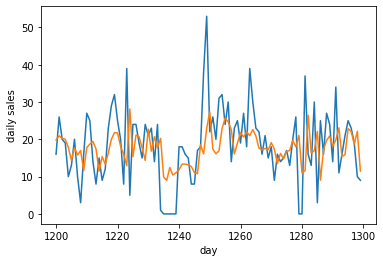

In [87]:
y_pred, _ = predict_random_item(df, item_id='FOODS_2_360_TX_3_validation', day=100)


## By Department

In [91]:
departs = ['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']
dept_mse = []
for depart in departs:
    test_dept = test_set[test_set[depart] == 1]

    y_dept_test = test_dept['sold']

    X_dept_test = test_dept[test_dept.columns[test_dept.columns != 'sold']]
    X_dept_test = X_dept_test.loc[:, ~X_dept_test.columns.isin(['id', 'd'])]
    X_dept_test = scaler.transform(X_dept_test)
    
    y_test_dept_predicted = lin_reg.predict(X_dept_test)

    d_mse = mse(y_test_dept_predicted, y_dept_test)
    dept_mse.append(d_mse)
    
    print(depart+'(' + str(len(test_dept)) + ') MSE:', d_mse)


FOODS_1(58406) MSE: 4.43257856382963
FOODS_2(112237) MSE: 3.2646904631699862
FOODS_3(191287) MSE: 13.324880057793084
HOBBIES_1(112924) MSE: 4.110112320422471
HOBBIES_2(38280) MSE: 0.29944466903696176
HOUSEHOLD_1(131950) MSE: 3.6661787010282563
HOUSEHOLD_2(141095) MSE: 0.5528599063766454


In [92]:
test_set.columns

Index(['id', 'd', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'Cultural', 'National', 'Religious',
       'Sporting', 'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri',
       'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1',
       'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3',
       'CA', 'TX', 'WI', 'rolling_mean_1_28', 'rolling_mean_7_28',
       'rolling_mean_14_28', 'rolling_mean_28_28', 'sold_lag_1', 'sold_lag_7',
       'sold_lag_14', 'sold_lag_28'],
      dtype='object')

## By Store

In [96]:
stores = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
store_mse = []

for store in stores:
    test_dept = test_set[test_set[store] == 1]

    y_dept_test = test_dept['sold']
    X_dept_test = test_dept[test_dept.columns[test_dept.columns != 'sold']]
    X_dept_test = X_dept_test.loc[:, ~X_dept_test.columns.isin(['id', 'd'])]
    X_dept_test = scaler.transform(X_dept_test)
    
    y_test_dept_predicted = lin_reg.predict(X_dept_test)
    d_mse = mse(y_test_dept_predicted, y_dept_test)
    store_mse.append(d_mse)
    
    print(store+'(' + str(len(test_dept)) + ') MSE:', d_mse)


CA_1(79931) MSE: 6.475986819380636
CA_2(70238) MSE: 3.206048092302813
CA_3(79968) MSE: 11.091780684957609
CA_4(77922) MSE: 2.4383425947732245
TX_1(80085) MSE: 6.572097488322451
TX_2(80015) MSE: 5.1999881911621415
TX_3(79575) MSE: 4.529741307592867
WI_1(79686) MSE: 2.8133508296809344
WI_2(79573) MSE: 7.760615566955861
WI_3(79186) MSE: 3.1211495823384907


## Evaluation

In [12]:
sampled_evaluation_data = generate_data(sales_evaluation, sampled_item_ids, 'test')


Combining data Done.
Cleaning data Done.
Reduce memory Done.


In [13]:
dev_start = int(max(sampled_evaluation_data['d'])) - 28
sampled_evaluation_28 = sampled_evaluation_data[sampled_evaluation_data['d'] > dev_start]

sampled_evaluation_28_x = sampled_evaluation_28.loc[:, ~sampled_evaluation_28.columns.isin(['id', 'd', 'sold'])]
sampled_evaluation_28_y = sampled_evaluation_28['sold']
sampled_evaluation_28_y_predicted = lin_reg.predict(scaler.transform(sampled_evaluation_28_x))

print('MSE', mse(sampled_evaluation_28_y, sampled_evaluation_28_y_predicted))


MSE 4.231781108822001


array([0.11492044, 0.12245829, 0.38770182, 0.41623575, 0.46576578,
       0.47042996, 0.41226918, 0.26400406, 0.38692362, 0.66681559,
       0.29936869, 0.99677164, 0.5385719 , 0.31697614, 0.26749188,
       0.48919064, 0.33371622, 0.72917826, 0.26218302, 0.34497721,
       0.41245157, 0.06737406, 0.17282755, 0.09473307, 0.33658487,
       0.51616556, 0.34496266, 0.65692789])

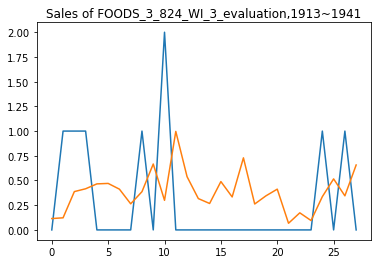

In [14]:
y_pred, y = predict_random_item(sampled_evaluation_data, item_id='FOODS_3_824_WI_3_evaluation')

y_pred


## Learning Curve

In [23]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(estimator = lin_reg, 
    X = X_train, y = y_train, train_sizes=np.linspace(.1, 1.0, 2), 
    cv = 2, scoring = 'neg_mean_squared_error')


In [21]:
train_scores, validation_scores



array([5.61582925e+23, 3.17696275e+23, 2.80927860e+24, 6.03294873e+22,
       2.16209409e+19, 9.79345262e+20, 8.70713178e+20, 2.23605248e+19,
       4.55779335e+00, 4.55745960e+00])

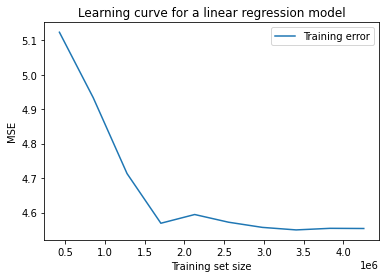

In [20]:
# plot 
train_scores_mean = (-train_scores).mean(axis = 1)
validation_scores_mean = (-validation_scores).mean(axis =1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('MSE')
plt.xlabel('Training set size')
plt.title('Learning curve for a linear regression model')
plt.legend()
plt.show()


# Utilities

In [25]:
# simply rearrange the helper functions for better modules
def generate_data(sales, sampled_item_ids, dataSource='train', 
                  day_cut=1200, merge=True, dropPriceNA=True):
    sampled_data = sales[sales['item_id'].isin(sampled_item_ids)]

    if dataSource=='train':
        df = combine_data(calendar, sell_price, sampled_data, 
                          day_cut=day_cut, merge=merge, dropPriceNA=dropPriceNA)
    else:
        df = combine_data(calendar, sell_price, sampled_data, 
                          merge=merge, dropPriceNA=dropPriceNA)

    df = clean_data(df)
    df = reduce_memory(df)
    
    # rolling mean features
    df = hf.rollingMeanDemandFeature(df, windowSize=1, shift=28)
    df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=28)
    df = hf.rollingMeanDemandFeature(df, windowSize=14, shift=28)
    df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=28)

    # lag features
    df = hf.lagFeature(df, var='sold', lag=1) 
    df = hf.lagFeature(df, var='sold', lag=7)
    df = hf.lagFeature(df, var='sold', lag=14)
    df = hf.lagFeature(df, var='sold', lag=28)

    df.dropna(inplace=True) # remove NaN due to lag and rolling
    
    return df


def load_data():
    calendar = hf.load_calendar_data()
    sell_price = hf.load_sell_price_data()
    sales_evaluation = hf.load_sales_train_evaluation_data()
    sales_validation = hf.load_sales_train_validation_data()

    print('Loading data Done.')
    return calendar, sell_price, sales_evaluation, sales_validation

def combine_data(calendar, sell_price, df, day_cut=1200, merge=False, dropPriceNA=False):
    '''
    convert wide data format to long data format, 
    merge data to a single dataframe
    get data that have 'd_' >= 1500
    '''
   
    # days cutoff
    # after day_cut [day_cut:]
    # data = df.loc[:, df.columns[0:6].tolist()+df.columns[day_cut+6:].tolist()]
    # before day_cut [0:day_cut]
    data = df.loc[:, df.columns[0:day_cut+6].tolist()]

    data = pd.melt(data, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = 'sold')

    # remove duplicates
    data = data.drop_duplicates()

    # merge
    if merge:
        data = pd.merge(data, calendar, on='d', how='left')
        data = pd.merge(data, sell_price, on=['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

    if dropPriceNA:
        data = data.dropna(subset=['sell_price'])

    print('Combining data Done.')
    return data


def clean_data(df):
    df = hf.cleanEvents(df)
    df = hf.cleanDates(df)
    df = hf.encodeItemAndStoreData(df)
    
    print('Cleaning data Done.')
    return df


def reduce_memory(data):
    data['d'] = data['d'].str.replace('d_', '').astype('int16')
    data[['month', 'year', 'wday', 'weekends']] = data[['month', 'year', 'wday', 'weekends']].astype('int16')

    data['sold'] = data['sold'].astype("int16")
    data["sell_price"] = data["sell_price"].astype("float16")
    data["item_id_cat"] = data["item_id_cat"].astype("int16")

    data[["snap_CA", "snap_TX", "snap_WI"]] = data[["snap_CA", "snap_TX", "snap_WI"]].astype("int8")

    print('Reduce memory Done.')

    

def reduce_memory(data):
    data['d'] = data['d'].astype('int16')
    data[['month', 'year', 'wday']] = data[['month', 'year', 'wday']].astype('int16')

    data['sold'] = data['sold'].astype("int16")
    data["sell_price"] = data["sell_price"].astype("float16")

    data[["snap_CA", "snap_TX", "snap_WI"]] = data[["snap_CA", "snap_TX", "snap_WI"]].astype("int8")

    print('Reduce memory Done.')
    
    return data


def stratified_sample(sales_validation, n_samples=1000):
    statify = sales_validation['item_id'].str.extract(r'([a-z|A-Z]+)(.+)')[0]

    sampled_item_ids = resample(sales_validation['item_id'], n_samples=n_samples, replace=False, stratify=statify, random_state=30)

    return sampled_item_ids


# def clean_data(data):
#     # null values
#     events_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
#     for f in events_features:
#         data[f].fillna('unknown', inplace = True)


#     # impute with the mean value
#     data["sell_price"].fillna(data.groupby("id")["sell_price"].transform("mean"), inplace=True)
    

#     # drop useless columns
 
#     print('Cleaning data Done.')

    
# def transform_data(data):
#     # lag features
#     lags = [7, 14, 28, 35]
#     for lag in lags:
#         data["lag_" + str(lag)] = data.groupby("id")["sold"].shift(lag).astype('float16')   


#     # rolling mean features
#     window=28
#     for period in [7, 14, 28, 35]:
#         data['rolling_mean_' + str(period)] = data.groupby('id')['sold'].transform(lambda x: x.shift(window).rolling(period).mean()).astype('float16')


#     # time features
#     data['date'] = pd.to_datetime(data['date'])
#     data['day'] = data['date'].dt.day.astype('int16')
#     data['weekends'] = np.where(data['date'].dt.dayofweek < 5, 0, 1)
#     data.drop(columns=["wm_yr_wk", 'weekday', "date"], inplace=True)


#     # remove NaN due to lag and rolling
#     data = data.dropna()

#     # categorical
#     cat = ['dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
#     for feature in cat:
#         fea = pd.get_dummies(data[feature], prefix=feature)
#         data = pd.concat([data, fea], axis=1)
#         data = data.drop([feature], axis=1)

#     labelencoder = LabelEncoder()
#     data['item_id_cat'] = labelencoder.fit_transform(data['item_id'])

#     print('Feature engineering Done.')
#     return data
